# Inteligência Artificial e Aprendizado de Máquina

**Prof. Dr. Francisco de Assis Boldt**  
**Pós-graduação em Desenvolvimento de Aplicações Inteligentes**  
**Inteligência Artificial e Aprendizado de Máquina — Atividade 01 - Regressão**  

**Nome:** Otávio Lube dos Santos  
**Matrícula:** 20231DEVAI0157

In [16]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [17]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [18]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [19]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

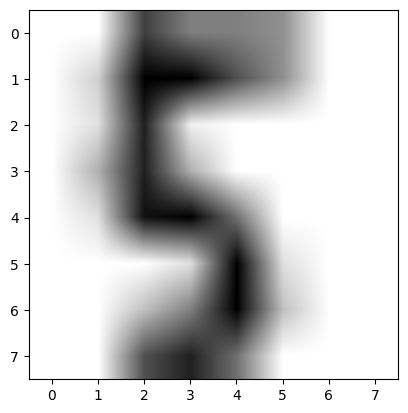

In [20]:
import matplotlib.pyplot as plt

plt.imshow(X_train[25].reshape(8,8), cmap='binary', interpolation="bilinear")
plt.show()

In [21]:
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digits_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digits_idx]

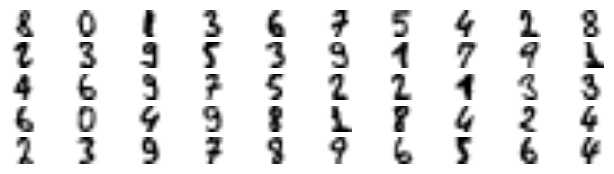

In [22]:
plt.figure(figsize=(8,2))
for index, X_representative_digit in enumerate(X_representative_digits):
  plt.subplot(k//10, 10, index+1)
  plt.imshow(X_representative_digit.reshape(8,8), cmap='binary', interpolation="bilinear")
  plt.axis("off")
plt.show()

In [23]:
import numpy as np

y_representative_digits = np.array([
    1, 9, 7, 0, 1, 6, 5, 6, 2, 4,
    3, 2, 9, 8, 5, 4, 1, 3, 8, 9,
    8, 4, 1, 0, 7, 7, 6, 5, 9, 3,
    4, 7, 1, 5, 1, 7, 8, 7, 9, 4,
    8, 2, 8, 2, 5, 6, 8, 9, 2, 6
])

In [24]:
y_representative_digits == y_train[representative_digits_idx]

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False])

In [25]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.15113350125944586

In [26]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
  y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [27]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.17884130982367757

In [28]:
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]
print(len(y_train_partially_propagated))

1309


In [29]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.18639798488664988

In [30]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.15889992360580596)

## Nova abordagem

In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [32]:
# Carregar o conjunto de dados
X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [42]:
# Aplicar o DBSCAN para clusterização
dbscan = DBSCAN(eps=12, min_samples=3)  # Ajuste os parâmetros conforme necessário
dbscan.fit(X_train)

DBSCAN(eps=12, min_samples=3)

In [46]:
# Encontrar exemplos representativos
unique_labels = np.unique(dbscan.labels_)
representative_idx = []

In [47]:
for label in unique_labels:
    if label == -1:  # Ignorar ruídos
        continue
    cluster_points = X_train[dbscan.labels_ == label]
    centroid = cluster_points.mean(axis=0)
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    representative_idx.append(np.argmin(distances) + np.where(dbscan.labels_ == label)[0][0])

# Verificar se há exemplos representativos suficientes
if len(representative_idx) == 0 or len(np.unique(y_train[representative_idx])) < 2:
    print("Exemplos representativos insuficientes. Usando amostragem aleatória como fallback.")
    from sklearn.utils import resample
    X_representative_digits, y_representative_digits = resample(
        X_train, y_train, n_samples=100, stratify=y_train, random_state=42
    )
else:
    X_representative_digits = X_train[representative_idx]
    y_representative_digits = y_train[representative_idx]

In [48]:
# Verificar distribuição de classes nos exemplos representativos
print(f"Distribuição das classes: {np.unique(y_representative_digits, return_counts=True)}")

# Treinar Regressão Logística com exemplos representativos
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
score_representative = log_reg.score(X_test, y_test)
print(f"Acurácia com exemplos representativos: {score_representative:.4f}")



Distribuição das classes: (array([0, 1, 2, 6, 7, 8]), array([2, 2, 1, 2, 1, 1]))
Acurácia com exemplos representativos: 0.4232


In [49]:
# Treinar Regressão Logística com exemplos representativos
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
score_representative = log_reg.score(X_test, y_test)
print(f"Acurácia com exemplos representativos: {score_representative:.4f}")

Acurácia com exemplos representativos: 0.4232


## Comparação entre as Abordagens

Regressão Logística com poucas amostras rotuladas (n_labeled = 50):

Acurácia: 75.82%

Regressão Logística com o dataset completo:

Acurácia: 90.93%

DBSCAN com exemplos representativos:

Acurácia: 42.32%

Distribuição das classes: (array([0, 1, 2, 6, 7, 8]), array([2, 2, 1, 2, 1, 1]))

Representou apenas algumas classes, o que prejudicou o desempenho.